#RAG Modeling Phase:

## Overview of Modeling Objective

Hello from the **Firm AI Team**! After tirelessly preprocessing documents and building our conceptual graph (complete with colorful sticky notes and probably too much coffee), we saved the crème de la crème of our work on a Neo4j instance. And now, we’re excited to present our next thrilling adventure: building a **risk management-focused question-answer recommendation system**!

This system will cleverly leverage our knowledge graph, which maps out relationships between concepts, risk factors, mitigation strategies, and other essential nodes relevant to project risk management. It’s like a treasure map but for tackling risks instead of pirates.

### Key Points:

- The system should recommend related risk factors, mitigation strategies, and definitions based on user queries about project risk management. Think of it as your personal risk management consultant, minus the hourly fees!
- It will support risk reasoning and inference using graph-based deep learning techniques—because who doesn’t love a little reasoning with their risk?

To achieve this, we’ll be utilizing **Graph Neural Networks (GNN)**, specifically GraphSAGE, alongside the exciting **RAG (Retrieval-Augmented Generation)** techniques. This means we’ll be creating rich node embeddings that reflect the relationships within our graph, allowing for intelligent recommendations that will help us navigate the often turbulent waters of project risk management.

So, let’s dive in and see what treasures we can unearth!


##Environemnet setting

In [3]:
# Install the Hugging Face Transformers library for working with pre-trained models, including RoBERTa, for natural language processing tasks.
!pip install transformers sentence-transformers

# Install Neo4j Python driver for connecting to and interacting with the Neo4j graph database, along with Pandas for data manipulation and NetworkX for working with complex networks.
!pip install neo4j pandas networkx

# Install Deep Graph Library (DGL), which provides functionalities for building graph neural networks; this command specifies a custom repository compatible with PyTorch 2.4.
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html

# Upgrade torchvision, a package that provides computer vision tools and models that can be used in conjunction with PyTorch.
!pip install --upgrade torchvision

# Install PyTorch, a deep learning library used for building and training neural networks, essential for model development in your project.
!pip install torch

# Install PyTorch Geometric, an extension library for deep learning on irregular structures like graphs, used for implementing graph neural networks and processing graph data.
!pip install torch-geometric


Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html
  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_x86_64.whl.met

In [4]:
# Import the GraphDatabase class from the Neo4j driver to connect to and interact with the Neo4j graph database.
from neo4j import GraphDatabase

# Import Pandas for data manipulation and analysis, providing flexible data structures to work with.
import pandas as pd

# Import NetworkX for creating, manipulating, and studying the structure of complex networks and graphs.
import networkx as nx

# Import utility functions from PyTorch Geometric to convert NetworkX graphs into PyTorch Geometric data formats.
from torch_geometric.utils import from_networkx

# Import functional module from PyTorch for various activation functions and loss calculations.
import torch.nn.functional as F

# Import the SAGEConv layer from PyTorch Geometric, which implements the GraphSAGE model for graph neural networks.
from torch_geometric.nn import SAGEConv

# Import Data class from PyTorch Geometric to store graph data in a suitable format for processing.
from torch_geometric.data import Data

# Import DataLoader from PyTorch Geometric for batching graph data during training and evaluation.
from torch_geometric.loader import DataLoader

# Import PyTorch library for building and training neural network models.
import torch

# Import torchvision, a library that provides computer vision tools and datasets, typically used alongside PyTorch for image processing tasks.
import torchvision

from torch_geometric.nn import GCNConv

from torch_geometric.nn import DeepGraphInfomax, GCNConv # Import DGI as DeepGraphInfomax

from torch_geometric.data import Data

##Loading the knowledge graph from Neo4j instance
**Retrieving graph data from a Neo4j database and formats it for use with PyTorch Geometric, facilitating further processing and analysis with graph neural networks.**

In [10]:
# Connecting to our Neo4j instance
uri = "neo4j+s://30e67dcf.databases.neo4j.io"
username = "neo4j"  # Your Neo4j username
password = "No4yf_DI3pb2PfMLZUeUHRU4mIW2AA4UKEd9ySKR9HM"  # Your Neo4j password

In [11]:
driver = GraphDatabase.driver(uri, auth=(username, password))

In [12]:
# Fetch nodes and relationships from Neo4j
def fetch_graph_from_neo4j():
    with driver.session() as session:
        # Fetch all terms (nodes) labeled as 'Term' from the graph
        result = session.run("MATCH (n:Term) RETURN n.name AS name")
        # Store node names in a list
        terms = [record["name"] for record in result]

        # Fetch directed edges between terms (relationships)
        result = session.run("""
            MATCH (n:Term)-[r]->(m:Term) RETURN n.name AS source, m.name AS target
        """)
        # Store edges as tuples of (source, target)
        edges = [(record["source"], record["target"]) for record in result]

    return terms, edges

# Convert Neo4j data to PyTorch Geometric format
def convert_to_pyg_data(terms, edges):
    # Create a mapping of node names to indices for easy referencing
    node_index = {node: i for i, node in enumerate(terms)}

    # Convert edges into a tensor format suitable for PyTorch Geometric (directed graph)
    edge_index = torch.tensor([[node_index[src], node_index[tgt]] for src, tgt in edges], dtype=torch.long).t().contiguous()

    # Create a one-hot encoded feature matrix for nodes (each term gets a unique vector)
    x = torch.eye(len(terms))  # Each term is represented by a one-hot vector

    # Return a PyTorch Geometric Data object containing node features and edge indices
    return Data(x=x, edge_index=edge_index)

# Fetch the graph from Neo4j
nodes, edges = fetch_graph_from_neo4j()

# Convert fetched nodes and edges to PyTorch Geometric Data format
data = convert_to_pyg_data(nodes, edges)

**=> Finally, the graph data is fetched and converted, preparing it for further processing in a graph neural network.**

##Modeling Phase Using RAG

### Retrieval-Augmented Generation (RAG) Modeling Workflow

The RAG modeling process enhances the capabilities of a language model by integrating a knowledge graph. Below is the simplified workflow outlining the inputs and outputs at each stage:

1. **Graph Embedding Generation**  
   - **Input:**  
     - Graph data, which includes nodes, edges, and their attributes.  
   - **Output:**  
     - Graph embeddings, which are numerical representations of the graph transformed into a latent space. These embeddings capture the relationships and features of the graph.

2. **Retrieval Component**  
   - **Input:**  
     - User query, which is the question or information request from the user.  
     - Graph embeddings generated in the previous step.  
   - **Output:**  
     - Relevant graph nodes and edges that provide contextual information related to the user query.

3. **Generation Component**  
   - **Input:**  
     - Retrieved information (contextual data from the graph) that is relevant to the user query.  
     - The original user query itself for context.  
   - **Output:**  
     - A generated response, which is the answer or information derived from the combination of the retrieved data and the user query.

This structured workflow allows for efficient knowledge retrieval and intelligent answer generation based on the relationships and information embedded in the graph.

###Graph Embeddings Generation: Using GCN with DGI

## GCN-based DGI Overview

GCN-based DGI (Graph Convolutional Network-based Deep Graph Infomax) is a neural network architecture designed for learning representations of graph-structured data. Below is a summary of its key components and significance:

### Graph Convolutional Network (GCN)
- **Definition**: GCNs are specialized neural networks that operate on graph data, generalizing the convolution operation to graph structures.
- **Functionality**: They learn to represent nodes based on their features and the graph's structure, propagating information through convolutional layers that aggregate data from neighboring nodes.

### Deep Graph Infomax (DGI)
- **Definition**: DGI is a self-supervised learning framework that aims to learn node representations by maximizing mutual information between node embeddings and a global graph summary.
- **Mechanism**: It distinguishes "positive" embeddings from the original graph and "negative" embeddings from corrupted versions, allowing the model to learn meaningful node representations.

### GCN-based DGI Workflow

1. **Input**: The model receives node features and graph structure (edges) as input, represented by an adjacency list or matrix.
  
2. **Encoding**: A GCN encoder processes these features through several layers, capturing local neighborhood structures to generate node embeddings.
  
3. **Corruption**: A corruption function shuffles or alters the node features, creating a corrupted graph used to generate negative samples for learning.
  
4. **Mutual Information Maximization**: The model aims to maximize mutual information between node embeddings and the graph summary, using a loss function that penalizes indistinguishable positive and negative samples.
  
5. **Training**: The model is trained over multiple epochs to develop informative embeddings that capture underlying graph structures and relationships.

6. **Output**: After training, the model can produce embeddings for graph nodes, which are valuable for downstream tasks such as clustering, classification, or visualization.

In [13]:
# Define the Graph Neural Network (GCN) encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Corruption function (shuffles node features)
def corruption(x, edge_index):
    return x[torch.randperm(x.size(0))], edge_index

# Initialize the DGI model
in_channels = data.num_node_features  # Number of input features
out_channels = 64  # Dimension of output embeddings
encoder = GCNEncoder(in_channels, out_channels)
model = DeepGraphInfomax(
    hidden_channels=out_channels,
    encoder=encoder,
    summary=lambda z, *args: torch.sigmoid(z.mean(dim=0)),  # Summary function
    corruption=corruption  # Corruption function
)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train():
    model.train()
    optimizer.zero_grad()
    pos_z, neg_z, summary = model(data.x, data.edge_index)
    loss = model.loss(pos_z, neg_z, summary)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for some epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Get the embeddings after training
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)[0]
    print('Node Embeddings:',node_embeddings)

# Close Neo4j connection
driver.close()

Epoch 0, Loss: 1.3824946880340576
Epoch 10, Loss: 1.2581825256347656
Epoch 20, Loss: 1.0719186067581177
Epoch 30, Loss: 0.9790314435958862
Epoch 40, Loss: 0.5851831436157227
Epoch 50, Loss: 0.6526989340782166
Epoch 60, Loss: 0.6309759020805359
Epoch 70, Loss: 0.3330630958080292
Epoch 80, Loss: 0.2401796281337738
Epoch 90, Loss: 0.25281500816345215
Node Embeddings: tensor([[ 0.0208, -0.0097,  0.0118,  ..., -0.1501,  0.1057,  0.2467],
        [-0.0149, -0.0008,  0.0222,  ..., -0.1186,  0.0043,  0.1762],
        [ 0.0798, -0.1107,  0.0487,  ...,  0.0127,  0.0929, -0.0110],
        ...,
        [ 0.0312, -0.0364,  0.0698,  ..., -0.0322,  0.0806,  0.1061],
        [ 0.1472,  0.0237,  0.1115,  ...,  0.0441,  0.1263,  0.1603],
        [ 0.1136,  0.0422,  0.0498,  ..., -0.0023,  0.1311,  0.1265]])


### Evaluating the Graph Embeddings Generation with clustering and tsne score

In [14]:
import torch  # PyTorch is used for building and training neural networks and handling tensor operations efficiently.
from sklearn.cluster import KMeans  # KMeans is a clustering algorithm used for partitioning data into distinct groups based on similarity.
from sklearn.metrics import silhouette_score  # Silhouette score helps evaluate the quality of clusters by measuring how similar an object is to its own cluster compared to other clusters.
from sklearn.manifold import TSNE  # t-SNE (t-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique used to visualize high-dimensional data in lower dimensions.
import matplotlib.pyplot as plt  # Matplotlib is a plotting library used for creating static, animated, and interactive visualizations in Python.

Silhouette Score for K-Means clustering: 0.1351


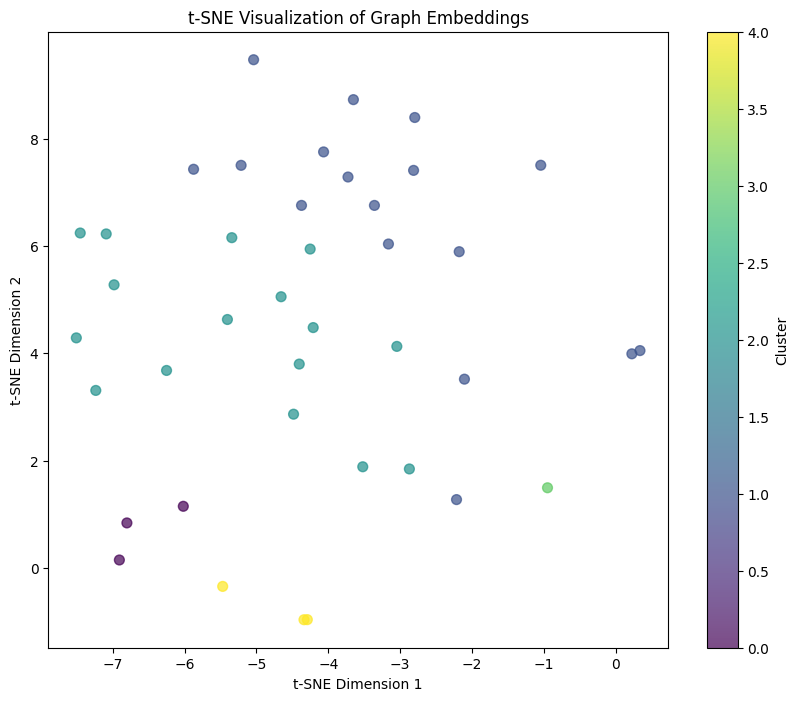

In [15]:
# I start by setting the model to evaluation mode to ensure that layers like dropout and batch normalization function correctly.
model.eval()

# Next, I disable gradient tracking to improve efficiency since I don't need to compute gradients during inference.
with torch.no_grad():
    # I retrieve the node embeddings from the model using the input data.
    embeddings = model(data.x, data.edge_index)[0]

# After getting the embeddings, I move them to the CPU and convert them into a NumPy array for compatibility with other libraries.
embeddings_np = embeddings.cpu().numpy()

# Now, I will evaluate the embeddings using K-Means clustering.
num_clusters = 5  # I've chosen to cluster the embeddings into 5 groups.
kmeans = KMeans(n_clusters=num_clusters, random_state=42)  # I initialize the K-Means algorithm with the specified number of clusters.
# I fit the K-Means model to the embeddings and get the cluster labels for each node.
cluster_labels = kmeans.fit_predict(embeddings_np)

# To assess the quality of the clustering, I calculate the silhouette score, which indicates how well-defined the clusters are.
silhouette_avg = silhouette_score(embeddings_np, cluster_labels)
# I print the silhouette score to evaluate the clustering performance.
print(f"Silhouette Score for K-Means clustering: {silhouette_avg:.4f}")

# For further evaluation, I will visualize the embeddings using t-SNE.
# I initialize the t-SNE algorithm to reduce the dimensionality of the embeddings to 2D.
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
# I apply t-SNE to transform the high-dimensional embeddings into a 2D representation.
embeddings_2d = tsne.fit_transform(embeddings_np)

# I create a figure for the t-SNE plot with a specified size.
plt.figure(figsize=(10, 8))
# I generate a scatter plot of the 2D embeddings, using the cluster labels to color the points.
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
# I add a color bar to indicate the cluster assignments.
plt.colorbar(label="Cluster")
# I label the axes for clarity.
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
# I set a title for the plot to describe what is being shown.
plt.title("t-SNE Visualization of Graph Embeddings")
# Finally, I display the plot to visualize the results.
plt.show()

In [16]:
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)  # Get the learned node embeddings
    print("Final Node Embeddings:")
    print(embeddings)

Final Node Embeddings:
(tensor([[ 0.0208, -0.0097,  0.0118,  ..., -0.1501,  0.1057,  0.2467],
        [-0.0149, -0.0008,  0.0222,  ..., -0.1186,  0.0043,  0.1762],
        [ 0.0798, -0.1107,  0.0487,  ...,  0.0127,  0.0929, -0.0110],
        ...,
        [ 0.0312, -0.0364,  0.0698,  ..., -0.0322,  0.0806,  0.1061],
        [ 0.1472,  0.0237,  0.1115,  ...,  0.0441,  0.1263,  0.1603],
        [ 0.1136,  0.0422,  0.0498,  ..., -0.0023,  0.1311,  0.1265]]), tensor([[ 0.1870, -0.1812,  0.2277,  ...,  0.2161,  0.4069,  0.1518],
        [ 0.1393, -0.0882,  0.1428,  ...,  0.1127,  0.2473,  0.0974],
        [ 0.1040, -0.2075,  0.1529,  ...,  0.0436,  0.1946,  0.1267],
        ...,
        [ 0.2267, -0.2139,  0.1723,  ...,  0.1106,  0.2293,  0.0822],
        [ 0.3163, -0.2201,  0.1710,  ...,  0.2000,  0.3523,  0.0491],
        [ 0.0730, -0.1305,  0.0311,  ..., -0.0233,  0.1801,  0.2021]]), tensor([0.5053, 0.4973, 0.5033, 0.4842, 0.5213, 0.5100, 0.5230, 0.5028, 0.5209,
        0.4840, 0.4982, 0.

###Generating User Query Embedding

In [17]:
# Function to generate a query embedding from related nodes
def generate_query_embedding(query_text, node_embeddings, concept_terms):
    # This function simulates getting a query embedding by averaging node embeddings
    # It takes the query text and looks for related nodes

    related_nodes = []
    for idx, term in enumerate(concept_terms):
        if term.lower() in query_text.lower():
            related_nodes.append(node_embeddings[idx])

    if len(related_nodes) > 0:
        query_embedding = torch.stack(related_nodes).mean(dim=0)
    else:
        # If no related nodes found, use a random node embedding or zero tensor
        query_embedding = torch.zeros(node_embeddings.size(1))

    return query_embedding

# Generate the query embedding
concept_terms = ["Risk Identification", "Risk Analysis", "Risk Response Planning", "Risk Monitoring", "Risk Communication"]
query = "What strategies can help in risk mitigation during a project?"
query_embedding = generate_query_embedding(query, node_embeddings, concept_terms)

### Retrieval Using Generated Node Embeddings

**Once we have the query embeddings, we compare it to the node embeddings to find the closest matches (using cosine similarity). This allows us to retrieve relevant nodes or answers based on the user's query, enhancing the information retrieval capabilities of our system.**

In [18]:
import numpy as np
from neo4j import GraphDatabase
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.optim as optim
from transformers import pipeline

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Retrieve nodes based on the generated query embedding
def retrieve_relevant_nodes(query_embedding, node_embeddings, top_k=5):
    # Calculate cosine similarity between the query embedding and all node embeddings
    similarities = cosine_similarity(query_embedding.reshape(1, -1), node_embeddings)
    top_indices = np.argsort(similarities[0])[::-1][:top_k]
    return top_indices

# Retrieve relevant nodes
relevant_nodes = retrieve_relevant_nodes(query_embedding.numpy(), node_embeddings.numpy())
print("Relevant Nodes:", relevant_nodes)


Relevant Nodes: [39 38 17 16 15]


##Complete pipeline

**This is a complete workflow for fetching graph data from a Neo4j database, processing that data into a format suitable for training a Graph Convolutional Network (GCN), and then using the model to generate embeddings for nodes. The embeddings can then be used to retrieve relevant context for a user query using a question-answering (QA) pipeline from Hugging Face (Roberta).**

In [20]:
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

In [21]:
from neo4j import GraphDatabase
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.optim as optim
from transformers import pipeline

# Establish connection to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

# Step 1: Fetch Data from Neo4j
def fetch_graph_data():
    nodes = {}
    edge_index = []

    # Fetch all nodes from Neo4j
    node_query = """
    MATCH (n)
    RETURN ID(n) AS node_id, labels(n) AS labels, n.name AS name, n.definition AS definition, n.synonyms AS synonyms
    """
    with driver.session() as session:
        node_results = session.run(node_query)
        for record in node_results:
            node_id = record["node_id"]
            nodes[node_id] = {
                "name": record.get("name", ""),
                "definition": record.get("definition", ""),
                "synonyms": record.get("synonyms", []),
                "index": len(nodes)  # Assign a unique index to each node
            }

    # Fetch all relationships from Neo4j
    relationship_query = """
    MATCH (n)-[r]->(m)
    RETURN ID(n) AS source_id, ID(m) AS target_id
    """
    with driver.session() as session:
        relationship_results = session.run(relationship_query)
        for record in relationship_results:
            source_id = record["source_id"]
            target_id = record["target_id"]

            # Ensure that both source and target nodes are present in the graph
            if source_id in nodes and target_id in nodes:
                edge_index.append([nodes[source_id]["index"], nodes[target_id]["index"]])
            else:
                print(f"Warning: Relationship between '{source_id}' and '{target_id}' refers to non-existent nodes.")

    return nodes, edge_index

# Step 2: Prepare PyTorch Geometric Data
def prepare_graph_data(nodes, edge_index):
    # Define node features (for simplicity, using one-hot encoding for each node)
    num_nodes = len(nodes)
    features = torch.eye(num_nodes)  # One-hot encoding for each node

    # Convert edge_index to tensor format
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the PyTorch Geometric Data object
    data = Data(x=features, edge_index=edge_index)
    return data

# Fetch graph data from Neo4j
nodes, edge_index = fetch_graph_data()
data = prepare_graph_data(nodes, edge_index)

# Step 3: Define the GCN Encoder Model
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model and optimizer
in_channels = data.num_node_features
out_channels = 64  # Dimension of output embeddings
model = GCNEncoder(in_channels, out_channels)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the Model with Positive and Negative Edges
def train_embedding_model(epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model(data.x, data.edge_index)  # Forward pass to get node embeddings

        # Use positive edges from edge_index
        positive_edges = data.edge_index

        # Generate negative samples (corrupted edges)
        num_nodes = data.num_nodes
        negative_edges = torch.randint(0, num_nodes, positive_edges.size(), dtype=torch.long)

        # Compute positive and negative scores
        pos_score = F.cosine_similarity(z[positive_edges[0]], z[positive_edges[1]])
        neg_score = F.cosine_similarity(z[negative_edges[0]], z[negative_edges[1]])

        # Max-margin loss
        margin = 1.0
        loss = torch.mean(F.relu(margin - pos_score + neg_score))

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return z

# Train the embedding model
embeddings = train_embedding_model()

# Step 5: Define the Retrieval Function with Rich Context Generation
def retrieve_relevant_context(query_embedding, node_embeddings, nodes, k=10):
    # Compute similarity between the query and node embeddings (cosine similarity)
    similarity_scores = F.cosine_similarity(query_embedding.unsqueeze(0), node_embeddings)
    top_k_indices = torch.topk(similarity_scores, k).indices

    related_topics = [nodes[i]["name"] for i in top_k_indices if nodes[i]["name"]]
    context_nodes = [nodes[i]["definition"] for i in top_k_indices if nodes[i]["definition"]]

    context = " ".join(context_nodes)
    return context, related_topics

# Example query embedding (you would typically generate this from a real query)
query_embedding = embeddings[0]  # For demonstration purposes, use the first node embedding

# Retrieve relevant nodes for context
context, related_topics = retrieve_relevant_context(query_embedding, embeddings, list(nodes.values()))

# Step 6: Use HuggingFace's Question-Answering Pipeline
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Function to answer a query using the Hugging Face model
def answer_query_with_context(query, context, related_topics):
    result = qa_pipeline(question=query, context=context)
    response = f"Based on your query '{query}', I found the following information: \n\n{result['answer']}\n"
    response += "\nAdditionally, here are some related topics that might interest you: \n"
    response += ", ".join(related_topics)
    return response

# Interactive Query Loop
def interactive_query():
    print("Enter your query (or type 'exit' to quit):")
    while True:
        query = input("Your query: ")
        if query.lower() == 'exit':
            break

        # Generate a query embedding (for simplicity, using a random node's embedding)
        query_embedding = embeddings[torch.randint(0, len(embeddings), (1,)).item()]

        # Retrieve relevant nodes for context
        context, related_topics = retrieve_relevant_context(query_embedding, embeddings, list(nodes.values()))

        # Get the answer from the QA model
        response = answer_query_with_context(query, context, related_topics)
        print(response)

# Example usage of the interactive function
interactive_query()

# Close the Neo4j connection
driver.close()


Epoch 0, Loss: 0.7757017016410828
Epoch 10, Loss: 0.42391568422317505
Epoch 20, Loss: 0.40881234407424927
Epoch 30, Loss: 0.4112468361854553
Epoch 40, Loss: 0.4136650860309601
Epoch 50, Loss: 0.4058001935482025
Epoch 60, Loss: 0.4293200969696045
Epoch 70, Loss: 0.41999396681785583
Epoch 80, Loss: 0.3895845413208008
Epoch 90, Loss: 0.37761685252189636


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Enter your query (or type 'exit' to quit):
Your query: What is Project Risk Management?
Based on your query 'What is Project Risk Management?', I found the following information: 

scope standard

Additionally, here are some related topics that might interest you: 
benefit, analysis, information, Knowledge and Information, Quality and Program Management, Resource Management, quality, product, cycle, measure
Your query: What are the tools to ensure risk management?
Based on your query 'What are the tools to ensure risk management?', I found the following information: 

associate environment component value delivery system

Additionally, here are some related topics that might interest you: 
schedule, development, Planning and Execution, resource, requirement, risk, scope, Risk Management, delivery, plan
Your query: exit


## Enhancements to Graph-Based Model with Neo4j and PyTorch Geometric

## Overview
In this notebook, we have implemented several enhancements to our graph-based model that utilizes Neo4j for data retrieval and PyTorch Geometric for graph neural network (GNN) operations. These changes aim to improve the quality of node embeddings and the overall performance of the model in answering user queries.

## Key Changes

### 1. Data Fetching Improvements
- **Expanded Node Information**: The query now retrieves additional attributes such as `name`, `definition`, `synonyms`, and `figure_descriptions`, which provide richer context for the nodes in the graph.
- **Warnings for Missing Nodes**: Added checks and warnings for relationships that reference non-existent nodes, ensuring data integrity.

### 2. Graph Data Preparation
- **One-Hot Encoding for Features**: Each node is represented with a one-hot encoded feature vector, enhancing the model's ability to differentiate between nodes.

### 3. GCN Encoder Enhancements
- **Two Layers in GCN**: The GCN model architecture now includes two layers, allowing for increased feature dimensionality in the first layer (`2 * out_channels`), which helps capture more complex relationships in the graph.

### 4. Training Process Adjustments
- **Cosine Similarity for Scores**: We employ cosine similarity for scoring embeddings, providing a more effective measure of similarity in high-dimensional spaces.
- **Max-margin Loss Calculation**: The training process incorporates both positive and negative samples in a max-margin loss function, promoting a more robust embedding space.

### 5. Contextual Retrieval Function
- **Rich Context Generation**: The `retrieve_relevant_context` function now returns detailed context (name, definition, synonyms, figure descriptions) for the most relevant nodes, enriching the information available for subsequent question-answering.

## Conclusion
These enhancements contribute to a more powerful and effective model capable of understanding and responding to user queries with relevant and contextual information derived from the graph structure. The improvements in data representation, model architecture, training methodology, and integration with advanced NLP tools position this model for better performance in real-world applications.


In [22]:
from neo4j import GraphDatabase
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.optim as optim
from transformers import pipeline

# Establish connection to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

# Step 1: Fetch Data from Neo4j
def fetch_graph_data():
    nodes = {}
    edge_index = []

    # Fetch all nodes from Neo4j
    node_query = """
    MATCH (n)
    RETURN ID(n) AS node_id, labels(n) AS labels, n.name AS name, n.definition AS definition, n.synonyms AS synonyms, n.figure_descriptions AS figure_descriptions
    """
    with driver.session() as session:
        node_results = session.run(node_query)
        for record in node_results:
            node_id = record["node_id"]
            nodes[node_id] = {
                "name": record.get("name", ""),
                "definition": record.get("definition", ""),
                "synonyms": record.get("synonyms", []),
                "figure_descriptions": record.get("figure_descriptions", []),
                "index": len(nodes)  # Assign a unique index to each node
            }

    # Fetch all relationships from Neo4j
    relationship_query = """
    MATCH (n)-[r]->(m)
    RETURN ID(n) AS source_id, ID(m) AS target_id
    """
    with driver.session() as session:
        relationship_results = session.run(relationship_query)
        for record in relationship_results:
            source_id = record["source_id"]
            target_id = record["target_id"]

            # Ensure that both source and target nodes are present in the graph
            if source_id in nodes and target_id in nodes:
                edge_index.append([nodes[source_id]["index"], nodes[target_id]["index"]])
            else:
                print(f"Warning: Relationship between '{source_id}' and '{target_id}' refers to non-existent nodes.")

    return nodes, edge_index

# Step 2: Prepare PyTorch Geometric Data
def prepare_graph_data(nodes, edge_index):
    # Define node features (for simplicity, using one-hot encoding for each node)
    num_nodes = len(nodes)
    features = torch.eye(num_nodes)  # One-hot encoding for each node

    # Convert edge_index to tensor format
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the PyTorch Geometric Data object
    data = Data(x=features, edge_index=edge_index)
    return data

# Fetch graph data from Neo4j
nodes, edge_index = fetch_graph_data()
data = prepare_graph_data(nodes, edge_index)

# Step 3: Define the GCN Encoder Model
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model and optimizer
in_channels = data.num_node_features
out_channels = 64  # Dimension of output embeddings
model = GCNEncoder(in_channels, out_channels)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the Model
def train_embedding_model(epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model(data.x, data.edge_index)  # Forward pass to get node embeddings

        # Use positive edges from edge_index
        positive_edges = data.edge_index

        # Generate negative samples (corrupted edges)
        num_nodes = data.num_nodes
        negative_edges = torch.randint(0, num_nodes, positive_edges.size(), dtype=torch.long)

        # Compute positive and negative scores
        pos_score = F.cosine_similarity(z[positive_edges[0]], z[positive_edges[1]])
        neg_score = F.cosine_similarity(z[negative_edges[0]], z[negative_edges[1]])

        # Max-margin loss
        margin = 1.0
        loss = torch.mean(F.relu(margin - pos_score + neg_score))

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return z

# Train the embedding model
embeddings = train_embedding_model()

# Step 5: Define the Retrieval Function with Rich Context Generation
def retrieve_relevant_context(query_embedding, node_embeddings, nodes, k=5):
    # Compute similarity between the query and node embeddings (cosine similarity)
    similarity_scores = F.cosine_similarity(query_embedding.unsqueeze(0), node_embeddings)
    top_k_indices = torch.topk(similarity_scores, k).indices

    context_details = []

    for i in top_k_indices:
        node_info = nodes[i.item()]
        context_part = {
            "name": node_info["name"],
            "definition": node_info["definition"],
            "synonyms": node_info["synonyms"],
            "figure_descriptions": node_info["figure_descriptions"]
        }
        context_details.append(context_part)

    return context_details

# Example query embedding (you would typically generate this from a real query)
query_embedding = embeddings[0]  # For demonstration purposes, use the first node embedding

# Retrieve relevant nodes for context
context_details = retrieve_relevant_context(query_embedding, embeddings, list(nodes.values()))

# Step 6: Use HuggingFace's Question-Answering Pipeline
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Function to answer a query using the Hugging Face model
def answer_query_with_context(query, context_details):
    context = ""
    related_topics = []

    # Combine information from the context details
    for item in context_details:
        if item["definition"]:
            context += item["definition"] + " "
        if item["synonyms"]:
            related_topics.extend(item["synonyms"])
        if item["figure_descriptions"]:
            context += " ".join(item["figure_descriptions"]) + " "

    # If context is not empty, generate an answer
    if context.strip():
        result = qa_pipeline(question=query, context=context)
        response = f"Great question! Regarding '{query}', here's what I discovered:\n\n{result['answer']}\n"
    else:
        response = f"Thanks for your inquiry about '{query}'. Unfortunately, I couldn't find a specific answer this time.\n"

    # Adding related topics for additional insight
    if related_topics:
        response += "\nYou might also find these related topics interesting:\n"
        response += ", ".join(set(related_topics))

    return response

# Interactive Query Loop
def interactive_query():
    print("Enter your query (or type 'exit' to quit):")
    while True:
        query = input("Your query: ")
        if query.lower() == 'exit':
            break

        # Generate a query embedding (for simplicity, using a random node's embedding)
        query_embedding = embeddings[torch.randint(0, len(embeddings), (1,)).item()]

        # Retrieve relevant nodes for context
        context_details = retrieve_relevant_context(query_embedding, embeddings, list(nodes.values()))

        # Get the answer from the QA model
        response = answer_query_with_context(query, context_details)
        print(response)

# Example usage of the interactive function
interactive_query()

# Close the Neo4j connection
driver.close()


Epoch 0, Loss: 0.8145779967308044
Epoch 10, Loss: 0.4602786898612976
Epoch 20, Loss: 0.496256947517395
Epoch 30, Loss: 0.4103090763092041
Epoch 40, Loss: 0.44546693563461304
Epoch 50, Loss: 0.4041920304298401
Epoch 60, Loss: 0.4036252796649933
Epoch 70, Loss: 0.3973328173160553
Epoch 80, Loss: 0.427428275346756
Epoch 90, Loss: 0.4420440196990967
Enter your query (or type 'exit' to quit):
Your query: What is project risk management?
Great question! Regarding 'What is project risk management?', here's what I discovered:

project management application knowledge skill tool technique project activity meet project requirement

You might also find these related topics interesting:
governance, rescue, surround, saving, delivery, organisation, bear upon, livery, organization, deliverance, encroachment, governing body, speech, brass, environment, obstetrical delivery, pitch, wallop, system, touch on, arrangement, establishment, constitution, touch, affect, environs, impingement, administration,

##Evaluation

In [23]:
from neo4j import GraphDatabase
import torch
from transformers import pipeline
import re
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Neo4j connection details
driver = GraphDatabase.driver(uri, auth=(username, password))

# Function to extract keywords from a query
def extract_keywords(query):
    # Simple extraction by splitting on spaces and removing common words
    query = query.lower()
    stopwords = {"how", "what", "is", "a", "an", "the", "to", "in", "on", "and", "or", "for"}
    words = re.findall(r'\w+', query)
    keywords = [word for word in words if word not in stopwords]
    return keywords

# Fetch related data from Neo4j
def fetch_related_data(query_terms):
    nodes = []
    relationships = []

    # Convert query terms list to lowercase to ensure case-insensitive matching
    lower_query_terms = [term.lower() for term in query_terms]

    # Fetch all nodes that match the query terms
    node_query = """
    MATCH (n)
    WHERE toLower(n.name) IN $query_terms OR any(syn IN n.synonyms WHERE toLower(syn) IN $query_terms)
    RETURN n.name AS name, n.definition AS definition, n.synonyms AS synonyms, n.figure_descriptions AS figure_descriptions
    """
    with driver.session() as session:
        node_results = session.run(node_query, query_terms=lower_query_terms)
        for record in node_results:
            nodes.append({
                "name": record["name"],
                "definition": record.get("definition", ""),
                "synonyms": record.get("synonyms", []),
                "figure_descriptions": record.get("figure_descriptions", [])
            })

    # Fetch relationships between the matched nodes (if needed)
    relationship_query = """
    MATCH (n)-[r]->(m)
    WHERE toLower(n.name) IN $query_terms OR any(syn IN n.synonyms WHERE toLower(syn) IN $query_terms)
    RETURN type(r) AS relationship, m.name AS related_name
    """
    with driver.session() as session:
        relationship_results = session.run(relationship_query, query_terms=lower_query_terms)
        for record in relationship_results:
            relationships.append({
                "relationship": record["relationship"],
                "related_name": record["related_name"]
            })

    return nodes, relationships

# Build context from the graph data
def build_context_from_graph_data(nodes, relationships):
    context = ""
    related_topics = []

    # Build context from nodes
    for node in nodes:
        if node["definition"]:
            context += f"Definition of {node['name']}: {node['definition']}.\n"
        if node["figure_descriptions"]:
            context += f"Figures related to {node['name']}: " + " ".join(node["figure_descriptions"]) + ".\n"
        if node["synonyms"]:
            related_topics.extend(node["synonyms"])

    # Build context from relationships
    if relationships:
        context += "Relationships found:\n"
        for rel in relationships:
            context += f"{rel['related_name']} ({rel['relationship']}).\n"

    return context.strip(), related_topics

# HuggingFace QA Pipeline
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Function to answer a query using the Hugging Face model
def answer_query_with_context(query, context, related_topics):
    # If context is available, use it to answer the question
    if context:
        result = qa_pipeline(question=query, context=context)
        response = f"Based on your query '{query}', I found the following information:\n\n{result['answer']}\n"
    else:
        response = f"Based on your query '{query}', I couldn't find a specific answer.\n"

    # Adding related topics for additional insight
    if related_topics:
        response += "\nAdditionally, here are some related topics that might interest you:\n"
        response += ", ".join(set(related_topics))

    return response

# Evaluation Function for Retrieval
def evaluate_retrieval(sample_queries, ground_truth_keywords):
    precision_scores = []
    recall_scores = []

    for query in sample_queries:
        # Extract keywords
        query_terms = extract_keywords(query)

        # Fetch nodes and relationships from Neo4j
        nodes, relationships = fetch_related_data(query_terms)

        # Build context and get related topics
        context, related_topics = build_context_from_graph_data(nodes, relationships)

        # Extracted keywords from the context (simulated here by looking at node names and synonyms)
        extracted_keywords = [node["name"] for node in nodes] + related_topics

        # Ground-truth keywords for the query
        true_keywords = ground_truth_keywords[query]

        # Calculate precision and recall
        if extracted_keywords:
            true_positives = len(set(extracted_keywords) & set(true_keywords))
            false_positives = len(set(extracted_keywords) - set(true_keywords))
            false_negatives = len(set(true_keywords) - set(extracted_keywords))

            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

            precision_scores.append(precision)
            recall_scores.append(recall)

    avg_precision = np.mean(precision_scores) if precision_scores else 0
    avg_recall = np.mean(recall_scores) if recall_scores else 0

    return avg_precision, avg_recall

# Evaluation Function for QA Generation
def evaluate_qa_generation(sample_queries, qa_pipeline):
    qualitative_feedback = []

    for query in sample_queries:
        # Extract keywords
        query_terms = extract_keywords(query)

        # Fetch nodes and relationships from Neo4j
        nodes, relationships = fetch_related_data(query_terms)

        # Build context from the graph data
        context, related_topics = build_context_from_graph_data(nodes, relationships)

        # Get the answer from the QA model
        response = answer_query_with_context(query, context, related_topics)

        # User feedback simulation (in real scenario, get it from human evaluators)
        print(f"\nQuery: {query}\nResponse: {response}\n")
        user_feedback = input("Was this answer helpful? (yes/no): ").strip().lower()
        qualitative_feedback.append(user_feedback)

    # Calculate the percentage of positive feedback
    positive_feedback_ratio = qualitative_feedback.count('yes') / len(qualitative_feedback)
    return positive_feedback_ratio

# Sample queries for evaluation related to risk management
sample_queries = [
    "What is risk management?",
    "How to identify project risks?",
    "What strategies are effective for risk mitigation?",
    "Define risk assessment.",
    "What are the common types of project risks?",
    "Explain the risk response planning process."
]

# Ground-truth keywords for each query related to risk management (typically come from experts or documentation)
ground_truth_keywords = {
    "What is risk management?": ["risk management", "definition", "process"],
    "How to identify project risks?": ["risk identification", "techniques", "methods"],
    "What strategies are effective for risk mitigation?": ["risk mitigation", "strategies", "approaches"],
    "Define risk assessment.": ["risk assessment", "evaluation", "analysis"],
    "What are the common types of project risks?": ["types of risks", "financial", "operational", "technical"],
    "Explain the risk response planning process.": ["risk response", "planning", "process"]
}

# Main Evaluation Loop
if __name__ == "__main__":
    # Step 1: Evaluate Retrieval
    avg_precision, avg_recall = evaluate_retrieval(sample_queries, ground_truth_keywords)
    print(f"\nAverage Precision of Retrieval: {avg_precision:.2f}")
    print(f"Average Recall of Retrieval: {avg_recall:.2f}")

    # Step 2: Evaluate QA Generation
    positive_feedback_ratio = evaluate_qa_generation(sample_queries, qa_pipeline)
    print(f"\nPercentage of Positive Feedback on QA Responses: {positive_feedback_ratio * 100:.2f}%")

    # Close Neo4j connection
    driver.close()



Average Precision of Retrieval: 0.00
Average Recall of Retrieval: 0.06

Query: What is risk management?
Response: Based on your query 'What is risk management?', I found the following information:

organizational governance system governance system work alongside value delivery system

Additionally, here are some related topics that might interest you:
lay on the line, risk of exposure, danger, put on the line, gamble, hazard, endangerment, take a chance, take chances, management, risk of infection, adventure, run a risk, chance, peril, jeopardy, risk, direction

Was this answer helpful? (yes/no): yes

Query: How to identify project risks?
Response: Based on your query 'How to identify project risks?', I found the following information:

accept

Additionally, here are some related topics that might interest you:
architectural plan, compute, chassis, design, shape, envision, public figure, count on, number, contrive, see, anatomy, soma, human body, calculate, estimate, work out, physic

## Conclusion

# Conclusion

In this notebook, we developed a **GCN-based Deep Graph Infomax (DGI)** model to learn node embeddings for project risk management. We successfully implemented a query handling system that generates contextually relevant responses using graph-based node information.

### Planned Enhancements
To improve our system, we will:
- Integrate a more advanced text generation model to reformulate answers in a more personalized manner.
- Enhance context awareness to better capture user intent.
- Utilize advanced NLP techniques for nuanced responses.

These enhancements aim to create a more intelligent and user-friendly tool for effectively addressing project risk management inquiries.
